Hierarchical clustering

Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample.

The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. The linkage criteria determines the metric used for the merge strategy:

    Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.

    Maximum or complete linkage minimizes the maximum distance between observations of pairs of clusters.

    Average linkage minimizes the average of the distances between all observations of pairs of clusters.

    Single linkage minimizes the distance between the closest observations of pairs of clusters.

AgglomerativeClustering can also scale to large number of samples when it is used jointly with a connectivity matrix, but is computationally expensive when no connectivity constraints are added between samples: it considers at each step all the possible merges.

FeatureAgglomeration

The FeatureAgglomeration uses agglomerative clustering to group together features that look very similar, thus decreasing the number of features. 

Example: 
Various Agglomerative Clustering on a 2D embedding of digits

Computing embedding
Done.
ward :	0.11s
average :	0.12s
complete :	0.15s
single :	0.04s


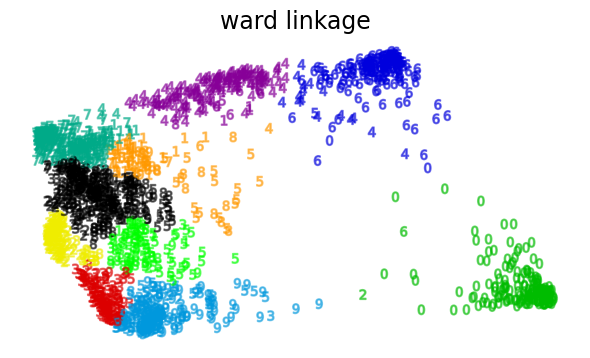

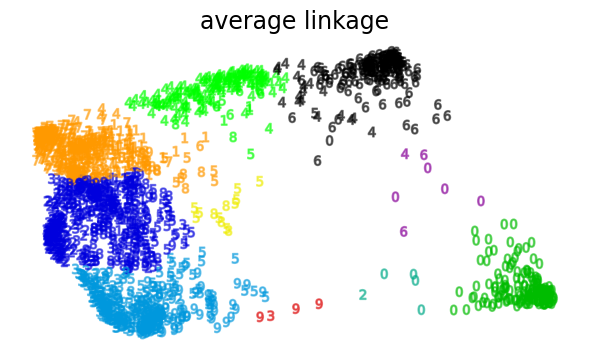

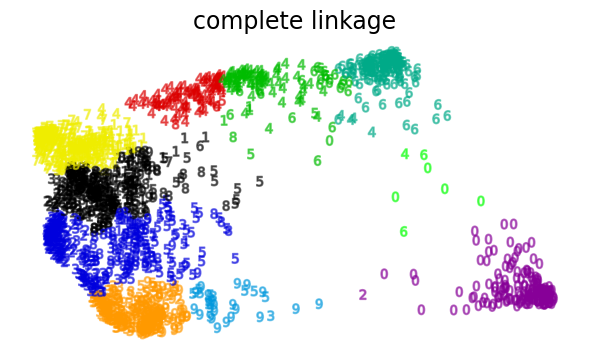

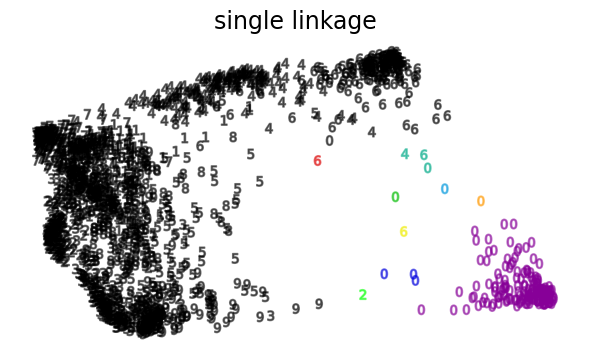

In [1]:
# Authors: Gael Varoquaux
# License: BSD 3 clause (C) INRIA 2014

from time import time

import numpy as np
from matplotlib import pyplot as plt

from sklearn import datasets, manifold

digits = datasets.load_digits()
X, y = digits.data, digits.target
n_samples, n_features = X.shape

np.random.seed(0)


# ----------------------------------------------------------------------
# Visualize the clustering
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for digit in digits.target_names:
        plt.scatter(
            *X_red[y == digit].T,
            marker=f"${digit}$",
            s=50,
            c=plt.cm.nipy_spectral(labels[y == digit] / 10),
            alpha=0.5,
        )

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])


# ----------------------------------------------------------------------
# 2D embedding of the digits dataset
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")

from sklearn.cluster import AgglomerativeClustering

for linkage in ("ward", "average", "complete", "single"):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(X_red)
    print("%s :\t%.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, clustering.labels_, "%s linkage" % linkage)


plt.show()

The Python code to cluster the customers with respect to these features is explored below.

structured Ward hierarchical clustering on an image of coins

In [2]:
from skimage.data import coins

orig_coins = coins()

In [3]:
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.transform import rescale

smoothened_coins = gaussian_filter(orig_coins, sigma=2)
rescaled_coins = rescale(
    smoothened_coins,
    0.2,
    mode="reflect",
    anti_aliasing=False,
)

X = np.reshape(rescaled_coins, (-1, 1))

In [4]:
from sklearn.feature_extraction.image import grid_to_graph

connectivity = grid_to_graph(*rescaled_coins.shape)

In [5]:
import time as time

from sklearn.cluster import AgglomerativeClustering

print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 27  # number of regions
ward = AgglomerativeClustering(
    n_clusters=n_clusters, linkage="ward", connectivity=connectivity
)
ward.fit(X)
label = np.reshape(ward.labels_, rescaled_coins.shape)
print(f"Elapsed time: {time.time() - st:.3f}s")
print(f"Number of pixels: {label.size}")
print(f"Number of clusters: {np.unique(label).size}")

Compute structured hierarchical clustering...
Elapsed time: 0.936s
Number of pixels: 4697
Number of clusters: 27


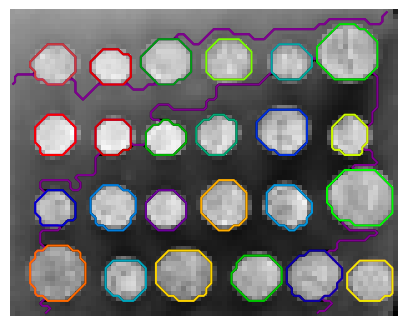

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(rescaled_coins, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(
        label == l,
        colors=[
            plt.cm.nipy_spectral(l / float(n_clusters)),
        ],
    )
plt.axis("off")
plt.show()

In a first step, the hierarchical clustering is performed without connectivity constraints on the structure and is solely based on distance, whereas in a second step the clustering is restricted to the k-Nearest Neighbors graph: it’s a hierarchical clustering with structure prior.

Some of the clusters learned without connectivity constraints do not respect the structure of the swiss roll and extend across different folds of the manifolds. On the opposite, when opposing connectivity constraints, the clusters form a nice parcellation of the swiss roll.

In [7]:
import time as time

# The following import is required
# for 3D projection to work with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
import numpy as np

In [8]:
from sklearn.datasets import make_swiss_roll

n_samples = 1500
noise = 0.05
X, _ = make_swiss_roll(n_samples, noise=noise)
# Make it thinner
X[:, 1] *= 0.5

In [9]:
from sklearn.cluster import AgglomerativeClustering

print("Compute unstructured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, linkage="ward").fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print(f"Elapsed time: {elapsed_time:.2f}s")
print(f"Number of points: {label.size}")

Compute unstructured hierarchical clustering...
Elapsed time: 0.09s
Number of points: 1500


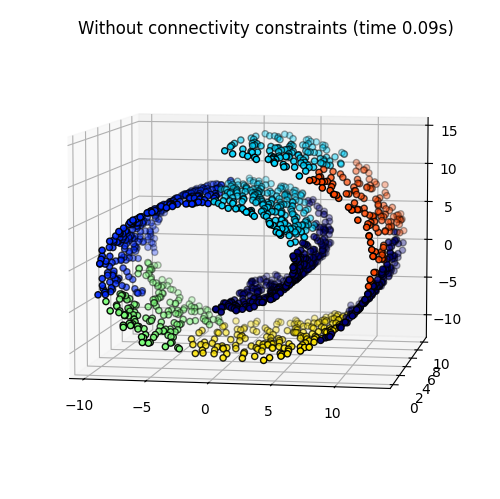

In [10]:
import matplotlib.pyplot as plt

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection="3d", elev=7, azim=-80)
ax1.set_position([0, 0, 0.95, 1])
for l in np.unique(label):
    ax1.scatter(
        X[label == l, 0],
        X[label == l, 1],
        X[label == l, 2],
        color=plt.cm.jet(float(l) / np.max(label + 1)),
        s=20,
        edgecolor="k",
    )
_ = fig1.suptitle(f"Without connectivity constraints (time {elapsed_time:.2f}s)")

In [11]:
from sklearn.neighbors import kneighbors_graph

connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)

In [12]:
print("Compute structured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(
    n_clusters=6, connectivity=connectivity, linkage="ward"
).fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print(f"Elapsed time: {elapsed_time:.2f}s")
print(f"Number of points: {label.size}")

Compute structured hierarchical clustering...
Elapsed time: 0.13s
Number of points: 1500


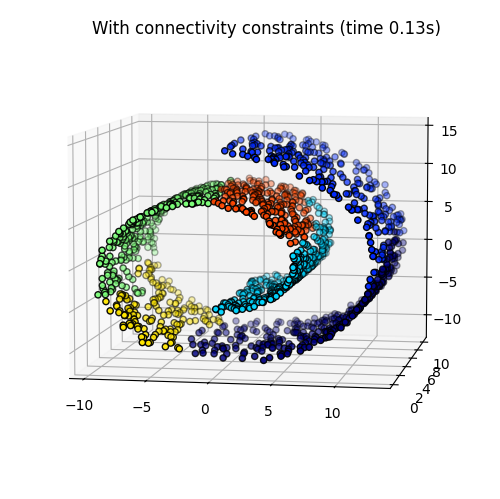

In [13]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(121, projection="3d", elev=7, azim=-80)
ax2.set_position([0, 0, 0.95, 1])
for l in np.unique(label):
    ax2.scatter(
        X[label == l, 0],
        X[label == l, 1],
        X[label == l, 2],
        color=plt.cm.jet(float(l) / np.max(label + 1)),
        s=20,
        edgecolor="k",
    )
fig2.suptitle(f"With connectivity constraints (time {elapsed_time:.2f}s)")

plt.show()

Comparing different hierarchical linkage methods on toy datasets
This example shows characteristics of different linkage methods for hierarchical clustering on datasets that are “interesting” but still in 2D.

In [14]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler